# Deep End-to-end Causal Inference: Demo Notebook

This notebook provides a showcase of the features provided by our open source code for Deep End-to-end Causal Inference (DECI).

 - We begin with a simple two node example, showing how DECI can orient an edge correctly when non-Gaussian noise is present, and how DECI can then be used for treatment effect estimation
 - We show how different graph constraints can be incorporated into DECI
 - We showcase DECI on a larger graph example

## Notebook Setup

### Setup on AML
Unzip Data file:
    
    unzip demo-data.zip

You can setup AML environment for causica by running the following commands on the terminal. Then, before running the notebook make sure you selected "causica" as your environment on top-right.

    conda create -y --name causica
    conda activate causica
    conda install -y pip
    conda install -y ipykernel
    python -m ipykernel install --user --name causica --display-name causica
    conda install python==3.9
    sudo apt install graphviz-dev
    pip install git+https://github.com/microsoft/causica@9826ee9ba7dd63d72aaa0b3e0fd09636e38dd5bc
    pip install azureml-mlflow==1.46.0

<!-- pip install -r requirements.txt -->
<!-- conda create -n "causica" python==3.9 ipython -->   

### Setup on Databricks
1. Upload demo-data.zip file as below (no need to unzip it):

Click New Icon New ![Icon New](https://learn.microsoft.com/en-us/azure/databricks/_static/images/icons/create-icon.png)> File upload.

Drag the zip file to the shared folder. For more info on upload data check [this link](https://learn.microsoft.com/en-us/azure/databricks/ingestion/add-data/upload-data)


2. Uncomment the following cell that will init-script on dbfs; set it up on your cluster. 
You can find more info on how to do so in this [link](https://learn.microsoft.com/en-us/azure/databricks/clusters/init-scripts#configure-a-cluster-scoped-init-script).

In [0]:
# %python
# dbutils.fs.put(
#     "dbfs:/databricks/init_scripts/install-pygraphviz-causica.sh",
#     """
#     #!/bin/bash
#     #install dependent packages
#     sudo apt-get install -y python3-dev graphviz libgraphviz-dev pkg-config
#     pip install pygraphviz
#     pip install git+https://github.com/microsoft/causica@9826ee9ba7dd63d72aaa0b3e0fd09636e38dd5bc""", True)

### Dataset availability
To use the notebook, the CSuite datasets need to be available. If you do not have the datasets, the CSuite data generation script in `causica/data_generation/csuite/simulate.py` in causica-repo will generate them for you. Make sure you have them before attempting to load datasets.

In [0]:
# Some imports to get us started
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['PYTHONWARNINGS'] = 'ignore::FutureWarning'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Utilities
import os
import pandas as pd
import numpy as np

# Causica imports
from causica.models.deci.deci import DECI
from causica.datasets.dataset import Dataset
from causica.datasets.variables import Variables

# Plots
import seaborn as sns
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# device: change cuda to cpu if GPU is not available; we recommend gpu training
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

# Part 1: Simplest example of end-to-end causal inference

## A) Dataset
Upload data: If you have the datasets, ensure that it is uploaded and the "data_dir" is set to the demo-data directory correctly.

If you want to generate the data from scratch, run the CSuite data generation script in `data_generation/csuite/simulate.py` from [causica repo](https://github.com/microsoft/causica/tree/main/causica), ensure that the CSuite datasets have been created under `./demo-data`, and ensure that the notebook's working directory has been set correctly.


### A1) Import the Simulated Data - Linexp_equal_variance

    Simulate from the graph (x0) -> (x1) with linear relationship.
    Turns into structural equations
    x0 ~ E_0(0, var_0)
    x1 = 0.5 * x_0 + sqrt(3)/2 * E_1(0, var_1)

    where E_0 and E_1 are any distributions corresponding to the noise variables of x0 and x1 with mean 0.
    E_0 and E_1 should have finite variance (possibly unequal).
    This ensures that the marginal distributions of x0 and x1 have mean 0.

In [0]:
# databricks
data_dir = "/dbfs/FileStore/shared_uploads/<user_name>/demo-data/demo-data/"

# local or aml
# data_dir = "demo-data/"

# Since csuite has multiple versions of dataset, we put all the files [train.csv, test.csv, all.csv, variables.json, and adj.csv] 
# for this experiment in one dataset_dir
dataset_dir="csuite_linexp_equal_variance"

In [0]:
# Import the sample multi-attribution data
file_path = os.path.join(data_dir, dataset_dir, "train.csv")
train_data = pd.read_csv(file_path, names=["A", "B"])

file_path = os.path.join(data_dir, dataset_dir, "test.csv")
test_data = pd.read_csv(file_path, names=["A", "B"])

In [0]:
# Data sample
print('Data Shape:', train_data.shape)
train_data.head()

Data Shape: (4000, 2)


A 
 B 
 
 
 
 
 0 
 0.038877 
 -0.683264 
 
 
 1 
 1.223592 
 1.241109 
 
 
 2 
 0.392550 
 -0.443539 
 
 
 3 
 -0.821275 
 -0.852504 
 
 
 4 
 0.029229 
 -0.709607

Initially, it is unclear what the causal relationship between A and B is.

Out[6]: <AxesSubplot: xlabel='A', ylabel='B'>

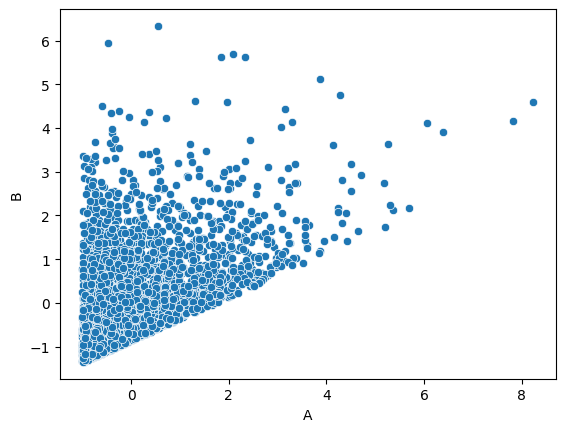

In [0]:
# plot
sns.scatterplot(x=train_data["A"], y=train_data["B"])

### A2) Import the Ground Truth Causal Effects
Unlike most real-world causal use cases, in this case we know the true causal relationships between treatments and outcome because we have simulated the data. We also extract those effects, created during data generation, to check our later causal effect estimates.

In [0]:
# we read as pandas to keep the node-names attached to the matrix
file_path = os.path.join(data_dir, dataset_dir, "adj_matrix.csv")
ground_truth_effects = pd.read_csv(file_path, names=["A", "B"]) # extract ground truth effects
ground_truth_effects.index = ["A", "B"]
ground_truth_effects

A 
 B 
 
 
 
 
 A 
 0 
 1 
 
 
 B 
 0 
 0

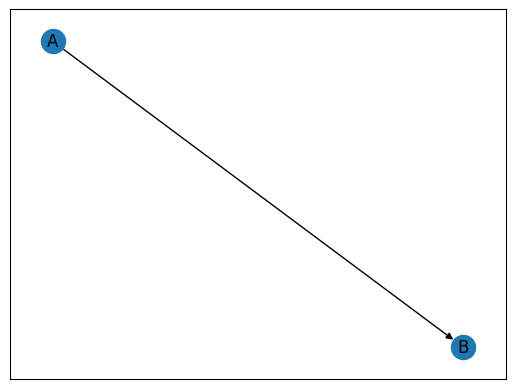

In [0]:
# plot with networkx
true_graph = nx.convert_matrix.from_pandas_adjacency(ground_truth_effects, create_using=nx.DiGraph)
nx.draw_networkx(true_graph, arrows=True, with_labels=True)

For a more consistent plotting of the graphs, we can do a topological sorting & plot it with the following function. This is only for a prettier and more consistent plotting as graph gets bigger; not much difference for a two-nodes graph! :)

In [0]:
def topological_plot(G):
    # G is a nx.DiGraph object
    for layer, nodes in enumerate(nx.topological_generations(G)):
        # `multipartite_layout` expects the layer as a node attribute, so add the
        # numeric layer value as a node attribute
        for node in nodes:
            G.nodes[node]["layer"] = layer
    # Compute the multipartite_layout using the "layer" node attribute
    pos = nx.multipartite_layout(G, subset_key="layer")
    fig, ax = plt.subplots()
    nx.draw_networkx(G, pos=pos, ax=ax)
    ax.set_title("DAG layout in topological order")
    fig.tight_layout()
    plt.show()

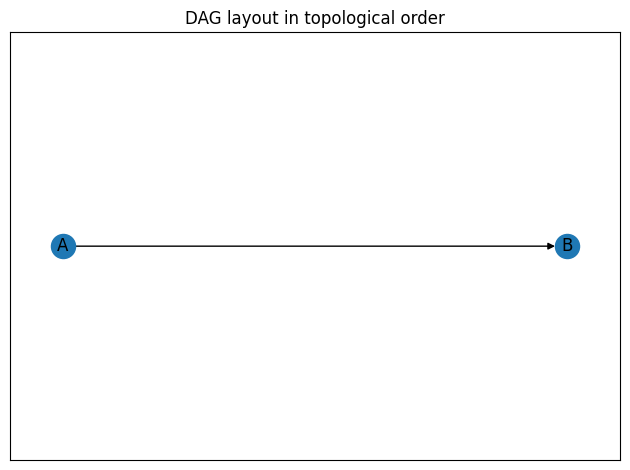

In [0]:
topological_plot(true_graph)

### A3) Load or create Variables object
Causica expect some meta-data information including variable types, the lower/higher bounds, their name, grouping (if any) and so on. The following function helps creating the features' information from a dataframe (causica.datasets.variables.Variables object). It is recommended that an expert review that to make sure the boundries and types are captured correctly and are valid for the unseen data, too.

In [0]:
def create_variables_json(df, categorical_vars, variables_json_path, text_vars=None, target_column_names=None):
    """
    The method returns Variables object (causica.datasets.variables.Variables), and also saves the json file; 
    The saved json file is for potential future use and the returned object is sufficient for what causica expects. 

    df <pandas.DataFrame> dataset that variable types and boundries will be extracted from
    categorical_vars <dict> a dictionary of categorical variables & the number of categories for each. e.g., {"gender":2, "race": 6}.
    variables_json_path <str> filepath to save the variables dictionary

    returns <causica.datasets.variables.Variables> variables
    """
    if text_vars is None:
        text_vars = []
    variables_info = []

    for ident, column_name in enumerate(df.columns):
        query = True if target_column_names is None else column_name not in target_column_names 
        var = {
            "id": ident,
            "query": query,
            "name": column_name,
        }
        if column_name not in text_vars:
            var["type"] = "categorical" if column_name in categorical_vars else "continuous"
            var["lower"] = 0 if column_name in categorical_vars else np.nanmin(df[column_name])
            var["upper"] = (
                categorical_vars[column_name] - 1 if column_name in categorical_vars else np.nanmax(df[column_name])
            )
        elif column_name in text_vars:
            var["type"] = "text"
            var["overwrite_processed_dim"] = 768  # Sentence Transformer model has that dimension

        if target_column_names and column_name in target_column_names:
            var["group_name"]="targets"
        variables_info.append(var)
    variables = Variables.create_from_dict({"variables": variables_info, "metadata_variables": []})
    variables.save(variables_json_path)
    return variables

In [0]:
# Load metadata telling us the data type of each column
file_path = os.path.join(data_dir, dataset_dir, "variables.json")
variables = create_variables_json(train_data, categorical_vars={}, variables_json_path=file_path)
# variables = Variables.create_from_data_and_dict(numpy_data, data_mask, variables)

Alternatively, if you have the json file for variable meta-data, you can just read it as below. You could also used the above function to save json file then manually modify if needed and reload it with the blow function:

In [0]:
# import json
# file_path = os.path.join(data_dir, "csuite_linexp_unequal_variance", "variables.json")
# with open(file_path) as f:
#     variables_dict = json.load(f)
#     variables = Variables.create_from_dict(variables_dict)

In [0]:
# Set up data in a suitable form for DECI to consume, using the loaded data types
data_mask = ~np.isnan(train_data.to_numpy()) # deci can tolerate missing data; this mask help DECI distinguish which data cell to use
numpy_data = train_data.fillna(0).to_numpy() # the missed cells will be masked out; so filling with any-value should not have impact
dataset = Dataset(train_data=numpy_data, train_mask=data_mask, variables=variables)

## B) Discover Causal Graph

### B1) Creating and training DECI model

The following snippets step through the process of:
 - configuring and creating a DECI model
 - training a model with no graph constraints
 - training a model with graph constraints
 
*Note*: if you have already trained a DECI model, you can reload the model by skipping to the section below on "Loading a saved DECI model"

#### **Note** -- DECI configuration

The DECI model has a number of hyperparameters, but attention need not be paid to all of them. Here we highlight key hyperparameters that might be changed to improve performance:
 - `learning_rate` is the step size for the Adam optimizer. Decrease the learning rate if training is unstable
 - `var_dist_A_learning_rate` is the learning rate for the causal graph distribution
 - `standardize_data_mean` and `standardize_data_std` tell DECI to standarize the data by subtracting the mean and dividing by the standard deviation of each column. *Note*: this improves training, but you need to take care because treatment effects will now be computed in this standardized space
 - `max_auglag_inner_epochs` is the number of gradient steps taken in each "inner step" of the DECI optimization. Decrease this to speed up training (at the risk of training not converging). Increase this to learn a more accurate model, or when the dataset is larger.
 - `max_steps_auglag` is the maximum number of "inner steps" taken. Decrease this to end training early (e.g. before a DAG has been found) to speed up training
 - `base_distribution_type` is the type of DECI model that is trained. It should be either `gaussian` or `spline`. Use `spline` for highly non-Gaussian data, or to fit a better density model of the observational data.
 - `lambda_sparse` controls the coefficient of graph sparsity regularizer.
 
Other hyperparameters are less frequently changed.


To speed up training you can try the followings:
 - increasing `learning_rate`
 - increasing `batch_size` (reduces noise when using higher learning rate)
 - decreasing `max_steps_auglag` (go as low as you can and still get a DAG)
 - decreasing `max_auglag_inner_epochs`

Note that an undertrained model might be unsuccessful to converge to a DAG or may have less accurate predictions.

In [0]:
# DECI configurations
model_config = {
    "tau_gumbel": 0.25,
    "lambda_dag": 200.0,
    "lambda_sparse": 5.0,
    "lambda_prior": 0.0,
    # Choosing a Gaussian DECI model, alternative is "spline"/"gaussian"
    "base_distribution_type": "spline",
    "imputation": False,
    "spline_bins": 8,
    "var_dist_A_mode": "enco",
    "mode_adjacency": "learn",
    # ?
    'norm_layers': True, 
    'res_connection': True,
}

training_params = {
    # Setting higher learning rates can speed up training, but risks some instability
    "learning_rate": 1e-3,
    "var_dist_A_learning_rate": 1e-2,
    "batch_size": 512, #256,
    # This standarizes the data before training. The DECI model operates in standardized space.
    "standardize_data_mean": False, #True,
    "standardize_data_std": False, #True,
    "rho": 1.0,
    "safety_rho": 1e18,
    "alpha": 0.0,
    "safety_alpha": 1e18,
    "tol_dag": 1e-9,
    "progress_rate": 0.65,
    # We are setting this large to wait until we find a DAG
    "max_steps_auglag": 5,
    # We are setting this large to learn a more accurate model.
    "max_auglag_inner_epochs": 2000,
    "max_p_train_dropout": 0.2,
    "reconstruction_loss_factor": 1.0,
    "anneal_entropy": "noanneal",
}

In [0]:
# we create a directory to save the results of all the experiments
deci_save_directory = "causica_deci_model"

In [0]:
# for each experiment we create a subdirectory (named after the dataset) in the deci_save_directory.
output_directory = os.path.join(deci_save_directory, dataset_dir)
model_name= "model_simple"

model = DECI.create(model_name, output_directory, dataset.variables, model_config, device=device)
model.run_train(dataset, training_params)

Saving logs to causica_deci_model/csuite_linexp_equal_variance/train_output/summary
Auglag Step: 0
LR: 0.001
Inner Step: 100, loss: 5.39, log p(x|A): -5.39, dag: 0.02172323, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 2.95e-06, cts_mse_icgnn: 3.32
Inner Step: 200, loss: 4.59, log p(x|A): -4.59, dag: 0.11947778, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.62e-05, cts_mse_icgnn: 4.35
Inner Step: 300, loss: 3.90, log p(x|A): -3.90, dag: 0.05430808, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 7.37e-06, cts_mse_icgnn: 5.94
Inner Step: 400, loss: 3.35, log p(x|A): -3.35, dag: 0.08689293, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.18e-05, cts_mse_icgnn: 7.24
Inner Step: 500, loss: 2.98, log p(x|A): -2.98, dag: 0.09775455, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.33e-

If we have a trained model we can load it as below:

In [0]:
model = DECI.load(model_name, output_directory, device=device)

Out[19]: <matplotlib.collections.PathCollection at 0x7f09bd9a9610>

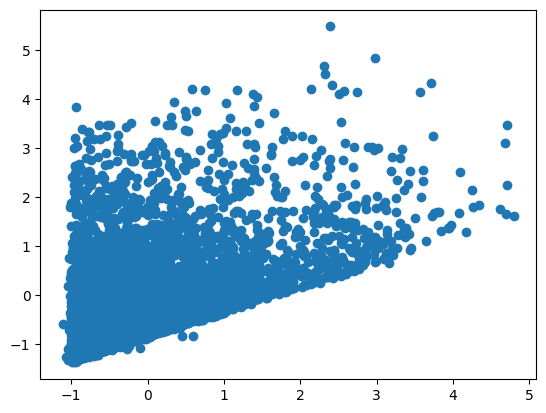

In [0]:
smpl=model.sample(5000)
plt.scatter(smpl[:,0],smpl[:,1])

### B2) Causal discovery results

In [0]:
model.networkx_graph().edges()

Out[20]: OutEdgeView([(0, 1)])

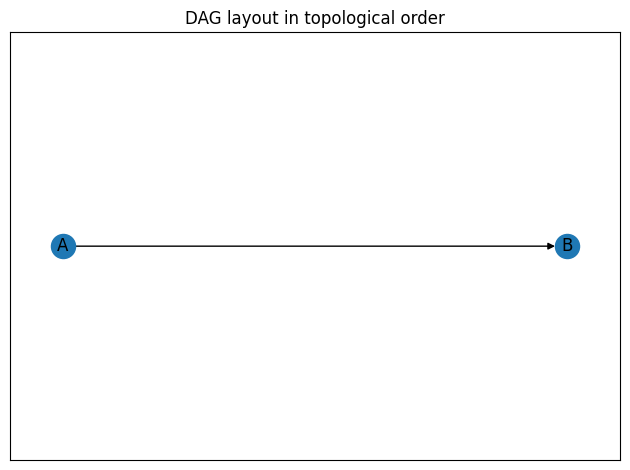

In [0]:
pred_graph = model.networkx_graph()
pred_graph = nx.relabel_nodes(pred_graph, {0:"A", 1:"B"})
topological_plot(pred_graph)

# nx.draw_networkx(pred_graph, arrows=True, with_labels=True, labels={0:"A", 1:"B"})

We can compare this with the true graph:

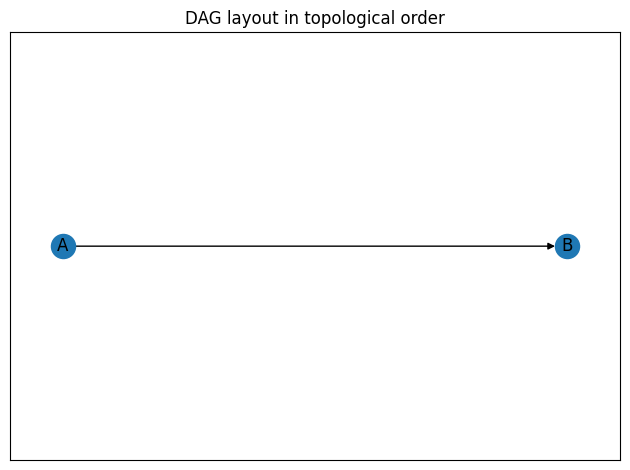

In [0]:
true_graph = nx.convert_matrix.from_pandas_adjacency(ground_truth_effects, create_using=nx.DiGraph)
topological_plot(true_graph)

# nx.draw_networkx(true_graph, arrows=True, with_labels=True)

### B3) Causal inference results

DECI has also fitted an SCM that captures the functional relationship and error distribution of this dataset.

#### Average treatment effect (ATE)
We can estimate ATE and compare it to the ATE estimate from ground truth interventional data. Here we will compute E[B|do(A=1)] - E[B|do(A=-1)].

As we know A _causes_ B, we expect changing A causes a change in B, but not the other way around:

In [0]:
# If we intervene on A ==> how B will change?
intervention_idxs = np.array([0])
outcome_idx = 1

### Model-based ATE estimate
do_1 = model.sample(5000, intervention_idxs=intervention_idxs, intervention_values=np.array([1.])).cpu().numpy()
do_minus_1 = model.sample(5000, intervention_idxs=intervention_idxs, intervention_values=np.array([-1.])).cpu().numpy()
ate_estimate = do_1[:, outcome_idx].mean() - do_minus_1[:, outcome_idx].mean()
print("Estimated ATE:", ate_estimate)

Estimated ATE: 0.99047065


On the predicted graph B _does not_ cause A, so we do not expect changing B have a significant impact on A, which matches the result below. 

**Note** that it is not exactly zero due to the probablistic nature of DECI. In another word, the pred-graph that we plotted is the most likely graph, but underlying the DECI computation each edge has a  _mighty_ existance with different levels of probablity! :) So the edge from B to A is insignificant but not fully **zero** according to the observed data.

In [0]:
# If we intervene on B ==> how A will change?
intervention_idxs = np.array([1])
outcome_idx = 0

### Model-based ATE estimate
do_1 = model.sample(5000, intervention_idxs=intervention_idxs, intervention_values=np.array([1.])).cpu().numpy()
do_minus_1 = model.sample(5000, intervention_idxs=intervention_idxs, intervention_values=np.array([-1.])).cpu().numpy()
ate_estimate = do_1[:, outcome_idx].mean() - do_minus_1[:, outcome_idx].mean()
print("Estimated ATE:", ate_estimate)

Estimated ATE: -0.050004154


Compare with ground truth (we have it on our test-data using the original synthetic data generator):

In [0]:
intervention_data = np.array(test_data.loc[test_data["A"]==1,:].reindex())
reference_data = np.array(test_data.loc[test_data["A"]==-1,:].reindex())

In [0]:
### Interventional test data ATE
outcome_idx=1
ate_true = intervention_data[:, outcome_idx].mean() - reference_data[:, outcome_idx].mean()
print("Interventional ATE:", ate_true)

Interventional ATE: 0.98733945299685


In [0]:
print("Theoretical ATE is 1.")

Theoretical ATE is 1.


Out[28]: <AxesSubplot: xlabel='A', ylabel='B'>

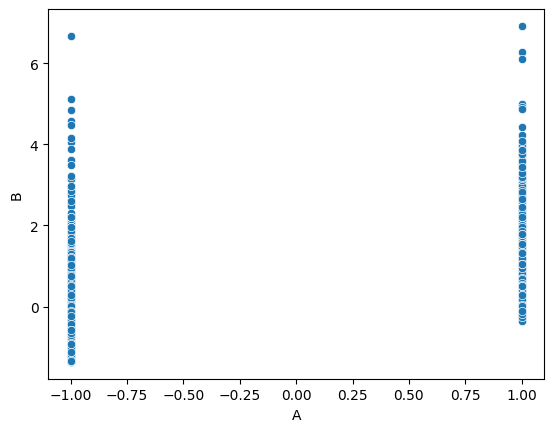

In [0]:
# ground-truth data
sns.scatterplot(x=test_data["A"], y=test_data["B"])

In short, we can start from data, do causal discovery and causal inference, yielding treatment effect estimates that actions can be based upon.

# Part 2: Complex Examples 
**Incorporate Knowledge about Graph Constraints**

## A) Train Simson Example - No Constraint
First, train on a new dataset with no constraints. *Note*: this is a very difficult dataset in which all variables are strongly correlated with one another.

### A1) Load Data
To load the dataset, first ensure that it has been generated under `./demo-data`

In [0]:
dataset_dir_simpson="csuite_nonlin_simpson"

# Import the sample multi-attribution data
train_data_simpson = pd.read_csv(os.path.join(data_dir, dataset_dir_simpson, "train.csv"), names=["A", "B", "C", "D"])
test_data_simpson = pd.read_csv(os.path.join(data_dir, dataset_dir_simpson, "test.csv"), names=["A", "B", "C", "D"])
all_data_simpson = pd.read_csv(os.path.join(data_dir, dataset_dir_simpson, "all.csv"), names=["A", "B", "C", "D"])

train_data_simpson.head(3)

A 
 B 
 C 
 D 
 
 
 
 
 0 
 -0.313854 
 -0.086297 
 -2.207146 
 -1.183498 
 
 
 1 
 0.055711 
 -0.248166 
 -0.817248 
 -0.760595 
 
 
 2 
 0.111356 
 -0.385469 
 -1.035435 
 -0.775432

In [0]:
# Load metadata telling us the data type of each column
variables_simpson = create_variables_json(train_data_simpson, categorical_vars={}, variables_json_path=os.path.join(
    data_dir, dataset_dir_simpson, "variables_simpson.json"))

# Set up data in a suitable form for DECI to consume, using the loaded data types
data_mask_simpson = ~np.isnan(train_data_simpson.to_numpy()) # deci can tolerate missing data
numpy_data_simpson = train_data_simpson.fillna(0).to_numpy()
dataset_simpson = Dataset(train_data=numpy_data_simpson, train_mask=data_mask_simpson, variables=variables_simpson)

# extract ground truth effects
gt_effects_simpson = pd.read_csv(os.path.join(data_dir, dataset_dir_simpson, "adj_matrix.csv"), names=["A", "B", "C", "D"]) 
gt_effects_simpson.index = ["A", "B", "C", "D"]

New dataset with 4 nodes.
The true graph is:


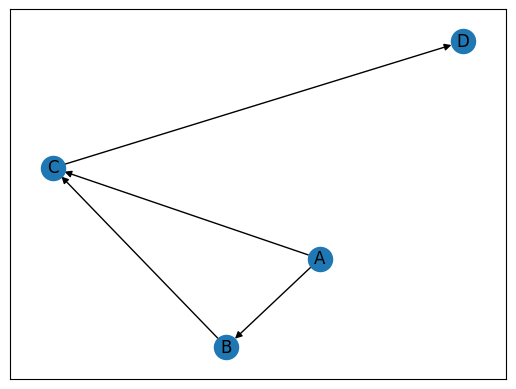

In [0]:
print(f"New dataset with {variables_simpson.num_groups} nodes.")
print("The true graph is:")

# topological_plot(nx.from_pandas_adjacency(gt_effects_simpson, create_using=nx.DiGraph))
nx.draw_networkx(nx.from_pandas_adjacency(gt_effects_simpson, create_using=nx.DiGraph))

### A2) Train model

In [0]:
output_directory_simpson=os.path.join(deci_save_directory, dataset_dir_simpson)
model_name_simpspon= "model_simpson"

model_simpson = DECI.create(model_name_simpspon, output_directory_simpson, dataset_simpson.variables, model_config, device=device)

# You may need more auglag steps / higher rho to make sure you do not get a non-DAG
training_params['max_auglag_inner_epochs'] = 2000
training_params['max_steps_auglag'] = 10

model_simpson.run_train(dataset_simpson, training_params)

Saving logs to causica_deci_model/csuite_nonlin_simpson/train_output/summary
Auglag Step: 0
LR: 0.001
Inner Step: 100, loss: 10.76, log p(x|A): -10.75, dag: 0.22129859, log p(A)_sp: -0.01, log q(A): -0.003, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 6.73e-05, cts_mse_icgnn: 6.01
Inner Step: 200, loss: 8.89, log p(x|A): -8.89, dag: 0.43134026, log p(A)_sp: -0.01, log q(A): -0.003, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.000191, cts_mse_icgnn: 4.1
Inner Step: 300, loss: 7.05, log p(x|A): -7.04, dag: 0.77116977, log p(A)_sp: -0.01, log q(A): -0.003, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.000415, cts_mse_icgnn: 3.22
Inner Step: 400, loss: 5.68, log p(x|A): -5.67, dag: 1.55717836, log p(A)_sp: -0.01, log q(A): -0.003, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00126, cts_mse_icgnn: 2.82
Inner Step: 500, loss: 4.71, log p(x|A): -4.69, dag: 1.27745362, log p(A)_sp: -0.01, log q(A): -0.003, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.000861, cts

[(1, 0), (1, 2), (1, 3), (2, 0), (3, 2)]


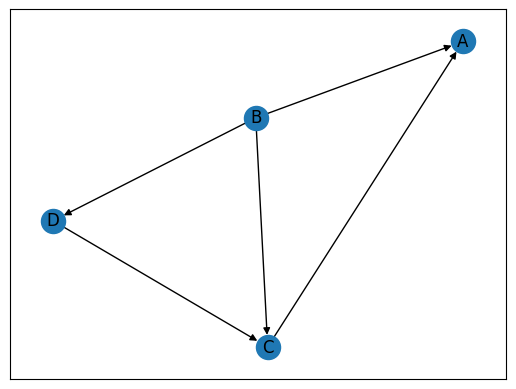

In [0]:
print(model_simpson.networkx_graph().edges)

pred_graph_simpson = model_simpson.networkx_graph()
nx.draw_networkx(pred_graph_simpson, arrows=True, with_labels=True, labels={0:"A", 1:"B", 2:"C", 3:"D"})

If we are not happy with this DAG, we could add some constraints.

## B) Incorporate Graph constraints - Simpson Example
Constraints are encoded using an adjacency matrix where:
 - 0 indicates that there is no directed edge i → j,
 - 1 indicates that there has to be a directed edge i → j,
 - nan indicates that the directed edge i → j is learnable.

### B1) Adding constraint that a node is not a child
Let's suppose that 'A' is not a child of anything (it's a root node).

In [0]:
# constraint matrix
constraint_simpson = np.full((variables_simpson.num_groups, variables_simpson.num_groups), np.nan, dtype=np.float32)
name_to_idx = {name: i for (i, name) in enumerate(variables_simpson.group_names)}
print(name_to_idx)

# node A is not a child
constraint_simpson[:, name_to_idx['A']] = 0.0

{'A': 0, 'B': 1, 'C': 2, 'D': 3}


You can skip the following function; it just shows some examples of how you can incorporate your knowledge of _tabu-nodes_ or _tabu-edges_:

In [0]:
# Another option: <!-- The following function converts from `tabu_` format into this matrix format, for use with DECI. -->
def make_constraint_matrix(variables, tabu_child_nodes=None,  tabu_parent_nodes=None, tabu_edges=None):
    """
    Makes a DECI constraint matrix from GCastle constraint format.

    Arguments:
        tabu_child_nodes: Optional[List[str]]
            nodes that cannot be children of any other nodes (root nodes)
        tabu_parent_nodes: Optional[List[str]]
            edges that cannot be the parent of any other node (leaf nodes)
        tabu_edge: Optional[List[Tuple[str, str]]]
            edges that cannot exist
    """

    constraint = np.full((variables.num_groups, variables.num_groups), np.nan)
    name_to_idx = {name: i for (i, name) in enumerate(variables.group_names)}
    if tabu_child_nodes is not None:
        for node in tabu_child_nodes:
            idx = name_to_idx[node]
            constraint[:, idx] = 0.0
    if tabu_parent_nodes is not None:
        for node in tabu_parent_nodes:
            idx = name_to_idx[node]
            constraint[idx, :] = 0.0
    if tabu_edges is not None:
        for source, sink in tabu_edges:
            source_idx, sink_idx = name_to_idx[source], name_to_idx[sink]
            constraint[source_idx, sink_idx] = 0.0
    return constraint.astype(np.float32)
# constraint = make_constraint_matrix(variables, tabu_child_nodes=['Column 0'])

In [0]:
# You may need more auglag steps / higher rho to make sure you do not get a non-DAG
training_params['max_auglag_inner_epochs'] = 2000
training_params['max_steps_auglag'] = 50

You can attach the constraints matrix & re-train now:

In [0]:
model_simpson = DECI.create(model_name_simpspon, output_directory, dataset_simpson.variables, model_config, device=device)
model_simpson.set_graph_constraint(constraint_simpson)
model_simpson.run_train(dataset_simpson, training_params)

Saving logs to causica_deci_model/csuite_linexp_equal_variance/train_output/summary
Auglag Step: 0
LR: 0.001
Inner Step: 100, loss: 10.75, log p(x|A): -10.75, dag: 0.05352996, log p(A)_sp: -0.00, log q(A): -0.003, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 1.31e-05, cts_mse_icgnn: 5.98
Inner Step: 200, loss: 8.86, log p(x|A): -8.85, dag: 0.15277966, log p(A)_sp: -0.01, log q(A): -0.003, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 4.9e-05, cts_mse_icgnn: 4.03
Inner Step: 300, loss: 6.97, log p(x|A): -6.97, dag: 0.25451363, log p(A)_sp: -0.01, log q(A): -0.003, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 6.99e-05, cts_mse_icgnn: 3.4
Inner Step: 400, loss: 5.69, log p(x|A): -5.68, dag: 0.20685939, log p(A)_sp: -0.01, log q(A): -0.003, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 7.07e-05, cts_mse_icgnn: 3.24
Inner Step: 500, loss: 4.58, log p(x|A): -4.57, dag: 0.21389022, log p(A)_sp: -0.01, log q(A): -0.003, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 7.78e-

In [0]:
print(model_simpson.networkx_graph().edges)

[(0, 1), (0, 2), (1, 2), (2, 3)]


Draw predicted Graph:

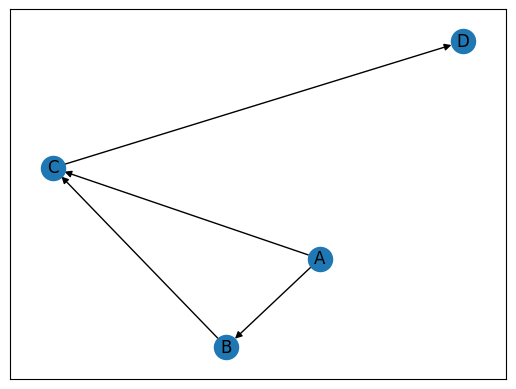

In [0]:
pred_graph_simpson = model_simpson.networkx_graph()
nx.draw_networkx(pred_graph_simpson, arrows=True, with_labels=True, labels={idx:name for name, idx in name_to_idx.items()})

### B2) Adding constraint that a node is not a parent
Suppose we also want to specify that 'D' is not a parent of anything (it's a leaf node).

In [0]:
constraint_simpson[name_to_idx["D"], :]=0

### B3) Adding constraint that an edge doesn't exist
Suppose we also want to specify that there is no edge from B to D.

In [0]:
# source: B, sink: D does not exist
constraint_simpson[name_to_idx["B"], name_to_idx["D"]]=0

### B4) Adding a positive constraint
It's also possible with DECI to force an edge to exist. For example, suppose we decide to enforce the existence of the egde from A to C.

In [0]:
# source: A, sink: C does exist
constraint_simpson[name_to_idx["A"], name_to_idx["C"]]=1.0
# constraint[0, 2] = 1.0

constraint_simpson

Out[42]: array([[ 0., nan,  1., nan],
       [ 0., nan, nan,  0.],
       [ 0., nan, nan, nan],
       [ 0.,  0.,  0.,  0.]], dtype=float32)

### Re-train
Again, we can re-train the model, by injecting more knowledge in the form of the above constraints

In [0]:
model_simpson = DECI.create(model_name_simpspon, output_directory_simpson, dataset_simpson.variables, model_config, device=device)
model_simpson.set_graph_constraint(constraint_simpson)
model_simpson.run_train(dataset_simpson, training_params)

In [0]:
print(model_simpson.networkx_graph().edges)

[(0, 1), (0, 2), (2, 1), (2, 3)]


In [0]:
print("The correct graph is ", [(0, 1), (0, 2), (1, 2), (2, 3)])

The correct graph is  [(0, 1), (0, 2), (1, 2), (2, 3)]


## C) Causal Inference

### C1) Conditional average treatment effect (CATE)
Suppose we want to compute the treatment effet of X1 on X2, but conditional for some fixed value of X0. For this, we use the cate method. The implementation of CATE involves fitting an auxiliary model, so it will be slower than ATE and counterfactual calculation. Note 1: there may be some variance in this estimate. Note 2: there are some restrictions on the graph for this method. Check the DECI paper for more info.

In [0]:
# e.g., let's codition on A=mean(A)-std(A) and see the impact of changing B on C. We change B from B=mean(B)-std(B) to B=mean(B)+std(B).  
treatment_values = train_data_simpson.mean(0) + train_data_simpson.std(0)
reference_values = train_data_simpson.mean(0) - train_data_simpson.std(0)

In [0]:
# The variable and value to condition on
conditioning_idxs = torch.tensor([0])
conditioning_values = torch.tensor([treatment_values[0]])

# The intervention variable, intervention value and reference value, same as for ATE
intervention_idxs = torch.tensor([1])
intervention_value = torch.tensor([treatment_values[1]])
reference_value = torch.tensor([reference_values[1]])

# The variables to compute the effect upon (this has to be length 1)
effect_idxs = torch.tensor([2])

# Set the parameters of the auxiliary CATE model
model_simpson.cate_rff_n_features = 100
cate_estimate, _ = model_simpson.cate(intervention_idxs, intervention_value, reference_value, effect_idxs, conditioning_idxs,
                              conditioning_values, Ngraphs=1000, Nsamples_per_graph=20)
print(cate_estimate)

[0.02044048]


The observation makes sense as we knew that B causes C; so even when A is conditioned (and stays the same), C is expected to change with a change in B.

Now, if we change A but condition it to C, we do not expect a _significant change_ in D:

In [0]:
# The variable and value to condition on
conditioning_idxs = torch.tensor([2])
conditioning_values = torch.tensor([treatment_values[2]])

# The intervention variable, intervention value and reference value, same as for ATE
intervention_idxs = torch.tensor([0])
intervention_value = torch.tensor([treatment_values[0]])
reference_value = torch.tensor([reference_values[0]])

# The variables to compute the effect upon (this has to be length 1)
effect_idxs = torch.tensor([3])

# Set the parameters of the auxiliary CATE model
model_simpson.cate_rff_n_features = 100
cate_estimate, _ = model_simpson.cate(intervention_idxs, intervention_value, reference_value, effect_idxs, conditioning_idxs,
                              conditioning_values, Ngraphs=1000, Nsamples_per_graph=20)
print(cate_estimate)

[0.00904152]


### C2) Sample
**Sample** is the underlying method used for both ATE and CATE calculation. For ATE estimation, we simply take the mean over multiple samples. For CATE, we fix an auxiliary regression model to the samples. Sample can be computed under any interventional distribution.

In [0]:
samples_simpson = model_simpson.sample(200000, intervention_idxs=torch.tensor([1]), intervention_values=torch.tensor([
    treatment_values[1]]), samples_per_graph=200)

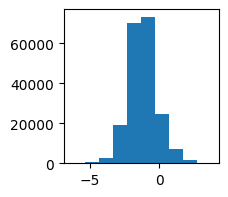

In [0]:
plt.figure(figsize=(2, 2))
plt.hist(samples_simpson[:, 2].cpu().numpy())
plt.show()

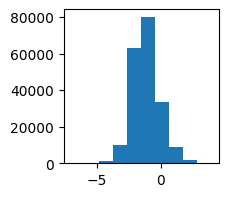

In [0]:
# Take samples under a different intervention
samples2_simpson = model_simpson.sample(200000, intervention_idxs=torch.tensor([1]), intervention_values=torch.tensor([
    reference_values[1]]), samples_per_graph=200)

plt.figure(figsize=(2, 2))
plt.hist(samples2_simpson[:, 2].cpu().numpy())
plt.show()

ATE is estimated by taking the difference of the average of the two sets of samples.

### C3) Counterfactual estimation

In [0]:
likely_graph_simpson = model_simpson.get_adj_matrix_tensor(samples=1, most_likely_graph=True)
factual_samples = train_data_simpson.values.astype('float32')
counterfactual_samples = model_simpson._counterfactual(factual_samples, likely_graph_simpson, 
                                               intervention_idxs=torch.tensor([1]),
                                               intervention_values=torch.tensor([reference_values[1]])
                                              ).detach().cpu().numpy()
counterfactual_simpson = pd.DataFrame(counterfactual_samples, columns=["A", "B", "C", "D"])

In [0]:
train_data_simpson.head(3)

A 
 B 
 C 
 D 
 
 
 
 
 0 
 -0.313854 
 -0.086297 
 -2.207146 
 -1.183498 
 
 
 1 
 0.055711 
 -0.248166 
 -0.817248 
 -0.760595 
 
 
 2 
 0.111356 
 -0.385469 
 -1.035435 
 -0.775432

In [0]:
counterfactual_simpson.head(3)

A 
 B 
 C 
 D 
 
 
 
 
 0 
 -0.313854 
 -0.824879 
 -2.207146 
 -1.183498 
 
 
 1 
 0.055711 
 -0.824879 
 -0.817248 
 -0.760595 
 
 
 2 
 0.111356 
 -0.824879 
 -1.035435 
 -0.775432

Observations:

- no change to column A: this makes sense because A is upstream of the variable we are intervening on, B
- B is set to the intervention value
- C and D change to their counterfactual values

### C4) Individual treatment effect (ITE)
Counterfactuals are the basis for computing ITEs. ITE does not involve resampling the noise. Unless there is significant graph uncertainty, it makes sense to use just the most likely graph, which is very fast

In [0]:
ite, _ = model_simpson.ite(factual_samples, intervention_idxs=torch.tensor([1]),
                   intervention_values=torch.tensor([treatment_values[1]]),
                   reference_values=torch.tensor([reference_values[1]]),
                   Ngraphs=1, most_likely_graph=True)
ite_df = pd.DataFrame(ite, columns=["A", "B", "C", "D"])
ite_df.head(3)

A 
 B 
 C 
 D 
 
 
 
 
 0 
 0.0 
 1.429174 
 0.0 
 0.0 
 
 
 1 
 0.0 
 1.429174 
 0.0 
 0.0 
 
 
 2 
 0.0 
 1.429174 
 0.0 
 0.0

The average ITE over the population should equal the ATE (approximately).

In [0]:
ite_df.mean(0)

Out[59]: A    0.000000
B    1.429174
C    0.000000
D    0.000000
dtype: float64

In [0]:
ate, _ = model_simpson.cate(intervention_idxs=torch.tensor([1]),
                    intervention_values=torch.tensor([treatment_values[1]]),
                    reference_values=torch.tensor([reference_values[1]]), Ngraphs=1000, Nsamples_per_graph=200)
print(ate)

[-7.16421190e-04  1.42917430e+00  4.06081656e-04  5.19890346e-06]


## D) A larger graph example
You can have a larger scale dataset & you may want to increase training-epochs as the dataset gets larger.

In [0]:
dataset_dir_large="csuite_large_backdoor"
colnames_large=[f"X{i}" for i in range(9)]

# Import the sample csuite_large_backdoor data
train_data_large = pd.read_csv(os.path.join(data_dir, dataset_dir_large, "train.csv"), names=colnames_large)
test_data_large = pd.read_csv(os.path.join(data_dir, dataset_dir_large, "test.csv"), names=colnames_large)

train_data_large.head(3)

X0 
 X1 
 X2 
 X3 
 X4 
 X5 
 X6 
 X7 
 X8 
 
 
 
 
 0 
 -0.549947 
 -1.854310 
 -1.431509 
 -1.941360 
 -1.307715 
 -1.985842 
 -0.944374 
 0.412794 
 0.637570 
 
 
 1 
 -0.255456 
 -1.374144 
 -0.456508 
 -1.273633 
 -0.709426 
 -0.768027 
 -1.533760 
 0.701445 
 0.708402 
 
 
 2 
 -0.201619 
 -1.481514 
 -0.532458 
 -1.821637 
 -0.790766 
 -1.503709 
 -1.112427 
 0.600610 
 1.461730

In [0]:
# Load metadata telling us the data type of each column
variables_large = create_variables_json(train_data_large, categorical_vars={}, variables_json_path=os.path.join(data_dir, dataset_dir_large, "variables.json"))

# Set up data in a suitable form for DECI to consume, using the loaded data types
data_mask = ~np.isnan(train_data_large.to_numpy()) # deci can tolerate missing data
numpy_data = train_data_large.fillna(0).to_numpy()
dataset_large = Dataset(train_data=numpy_data, train_mask=data_mask, variables=variables_large)

# extract ground truth effects
gt_effects_large = pd.read_csv(os.path.join(data_dir, dataset_dir_large, "adj_matrix.csv"), names=colnames_large)
gt_effects_large.index = colnames_large

# name-to-index
name_to_idx = {name: i for (i, name) in enumerate(variables_large.group_names)}
idx_to_name = {i: name for (i, name) in enumerate(variables_large.group_names)}


New dataset with 9 nodes.
The true graph is:


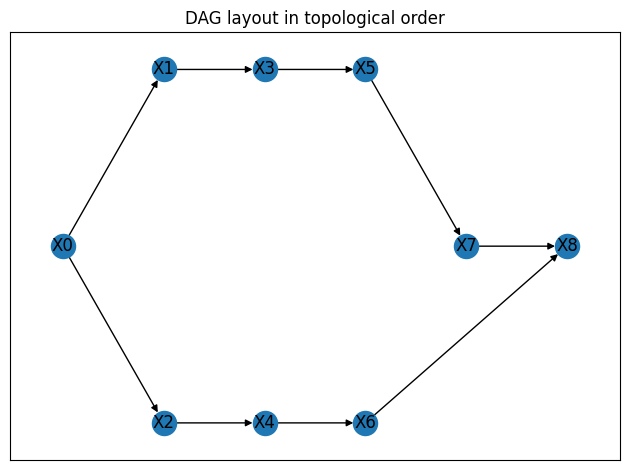

In [0]:
print(f"New dataset with {variables_large.num_groups} nodes.")
print("The true graph is:")
# nx.draw_networkx(nx.from_pandas_adjacency(gt_effects_large, create_using=nx.DiGraph))
topological_plot(nx.from_pandas_adjacency(gt_effects_large, create_using=nx.DiGraph))


Plot pair-wise columns if there are not too many columns, to get some sense of the relations:

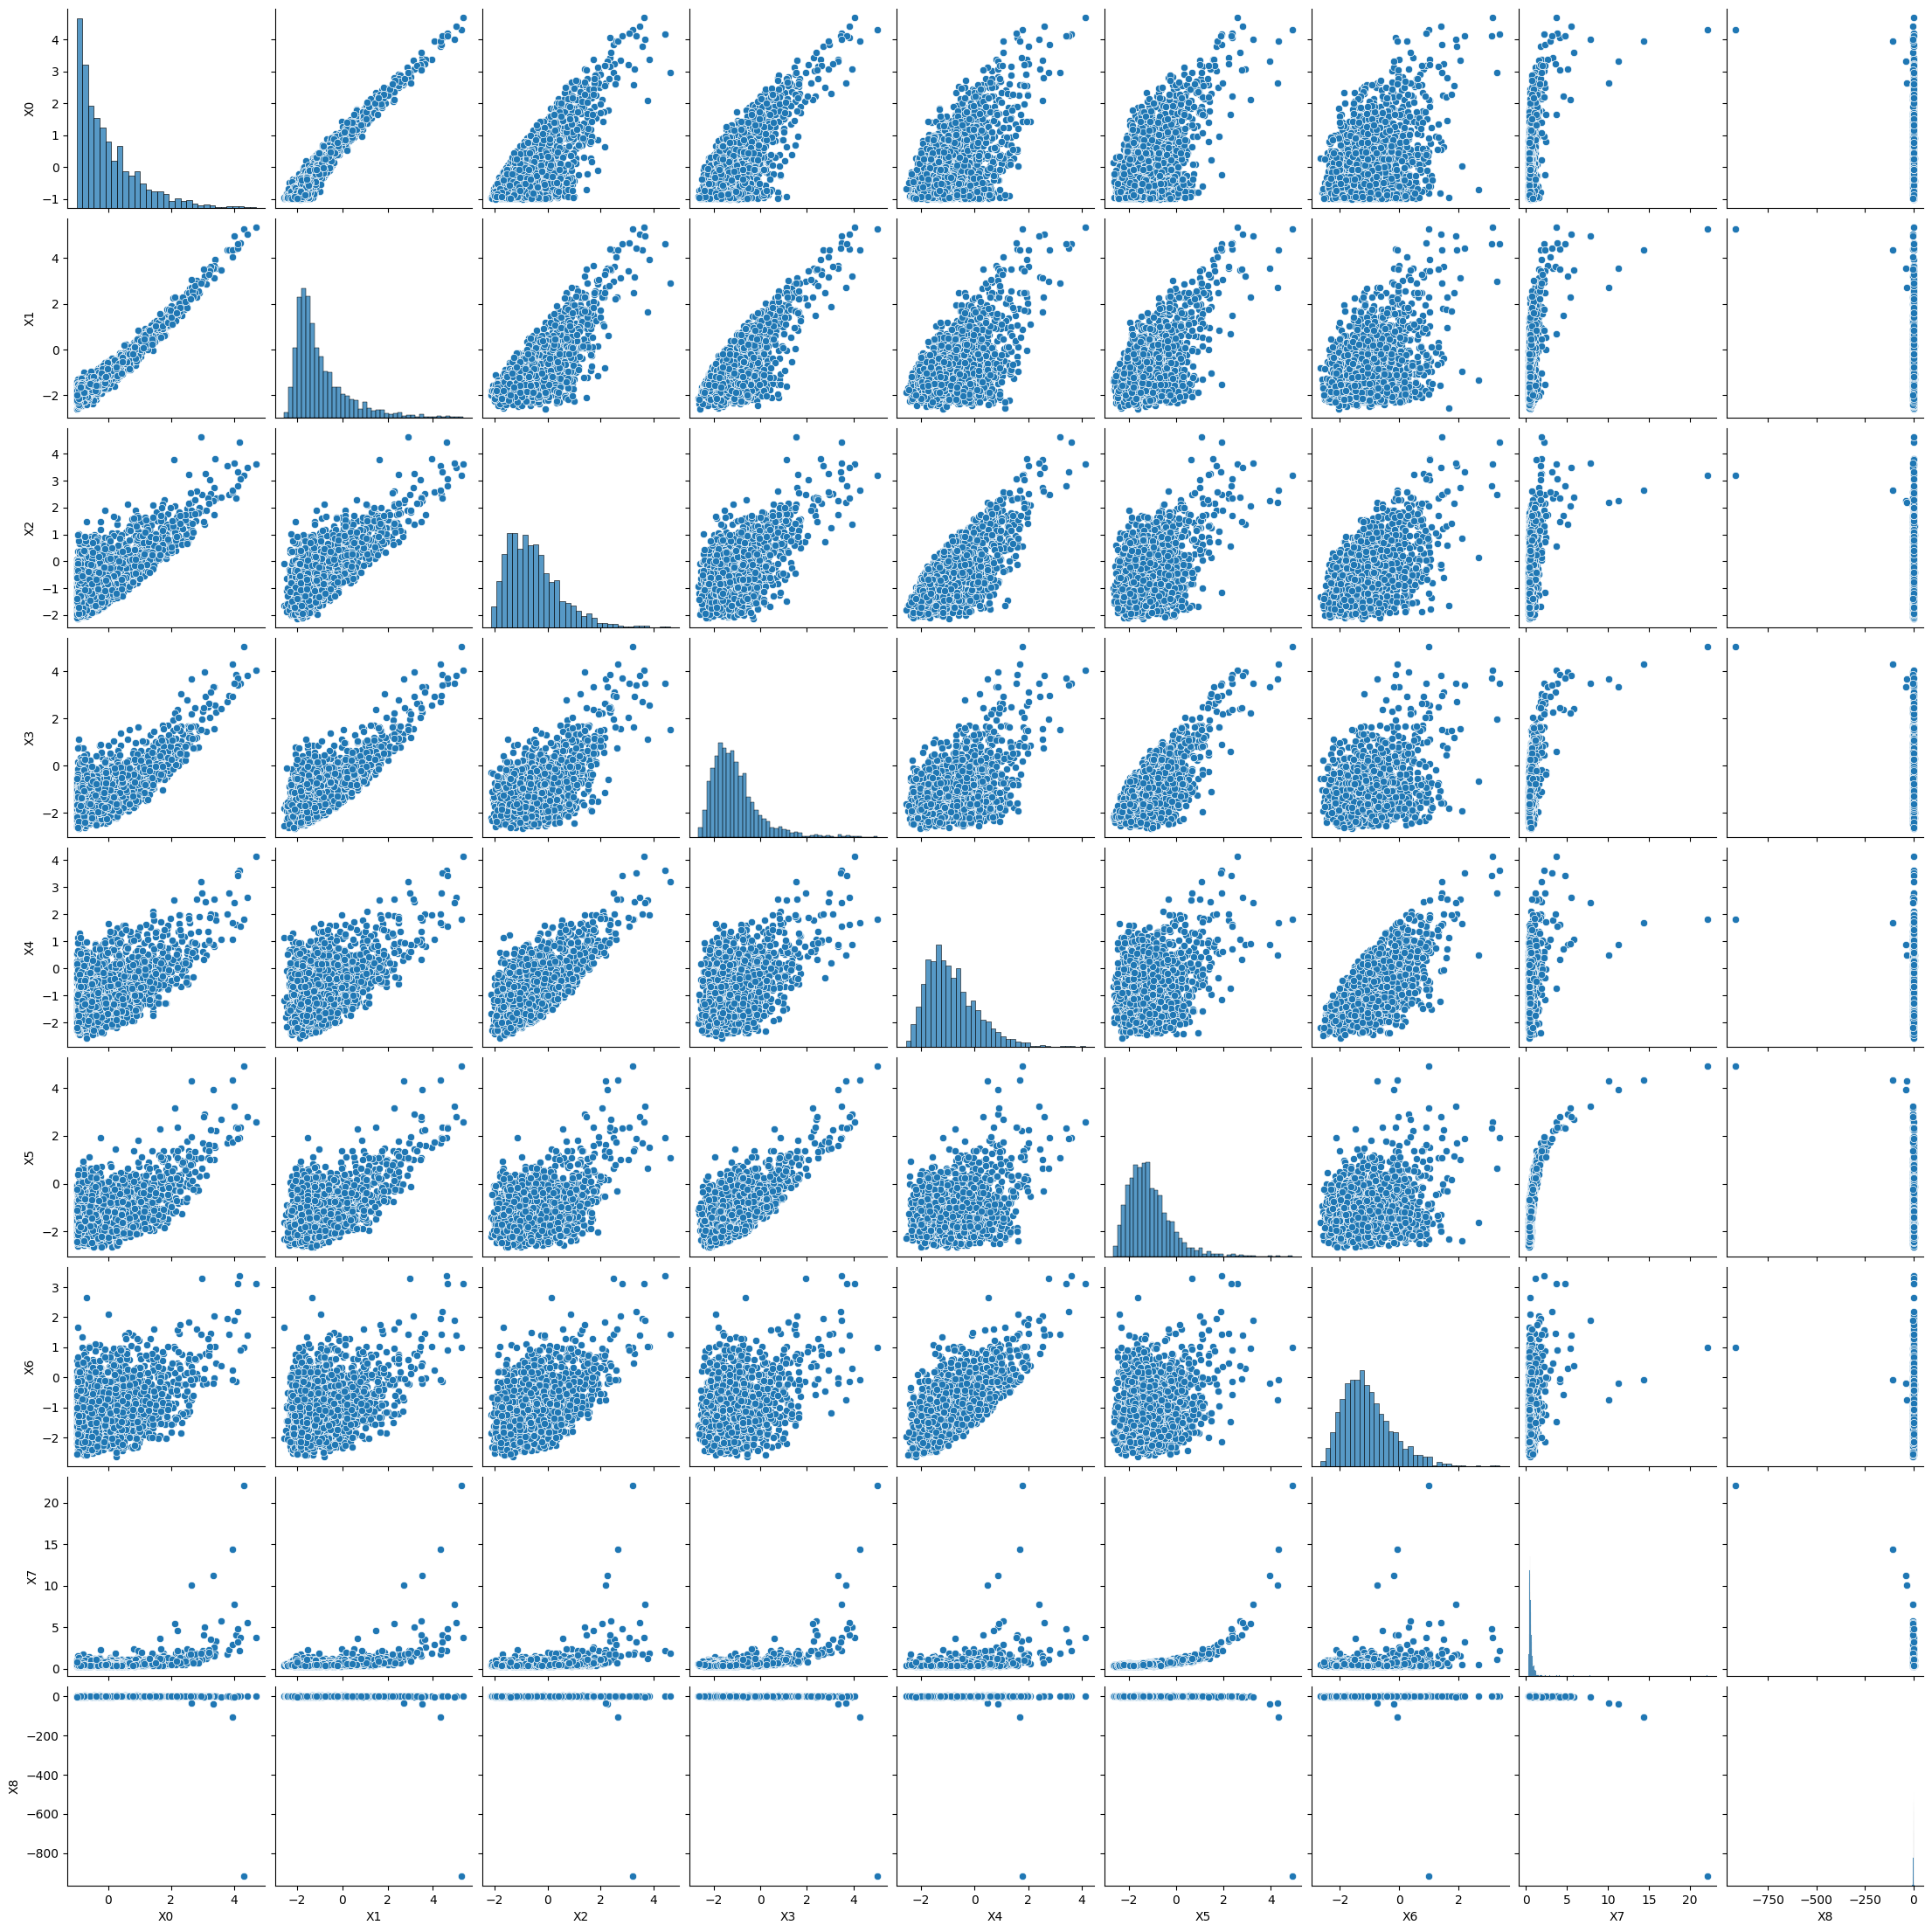

In [0]:
if train_data_large.shape[1] < 15:
    sns.pairplot(train_data_large)

In [0]:
# retrain with more epochs
model_config["imputation"]=False
training_params['max_steps_auglag'] = 100
training_params['max_auglag_inner_epochs'] = 3000

model_name_large = "model_large"
output_directory_large = os.path.join(deci_save_directory, dataset_dir_large)

model_large = DECI.create(model_name_large, output_directory_large, dataset_large.variables, model_config, device=device)
model_large.run_train(dataset_large, training_params)

Saving logs to causica_deci_model/csuite_large_backdoor/train_output/summary
Auglag Step: 0
LR: 0.001
Inner Step: 100, loss: 27.98, log p(x|A): -27.97, dag: 1.11013835, log p(A)_sp: -0.03, log q(A): -0.015, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.000856, cts_mse_icgnn: 445
Inner Step: 200, loss: 23.70, log p(x|A): -23.68, dag: 2.33137630, log p(A)_sp: -0.03, log q(A): -0.016, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00245, cts_mse_icgnn: 434
Inner Step: 300, loss: 19.72, log p(x|A): -19.69, dag: 3.86745460, log p(A)_sp: -0.04, log q(A): -0.016, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00525, cts_mse_icgnn: 441
Inner Step: 400, loss: 16.46, log p(x|A): -16.42, dag: 4.30826263, log p(A)_sp: -0.05, log q(A): -0.015, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00723, cts_mse_icgnn: 436
Inner Step: 500, loss: 14.24, log p(x|A): -14.20, dag: 3.93931239, log p(A)_sp: -0.05, log q(A): -0.015, H filled: 0.000, rec: 0.000, penalty_dag_weighed: 0.00537, c

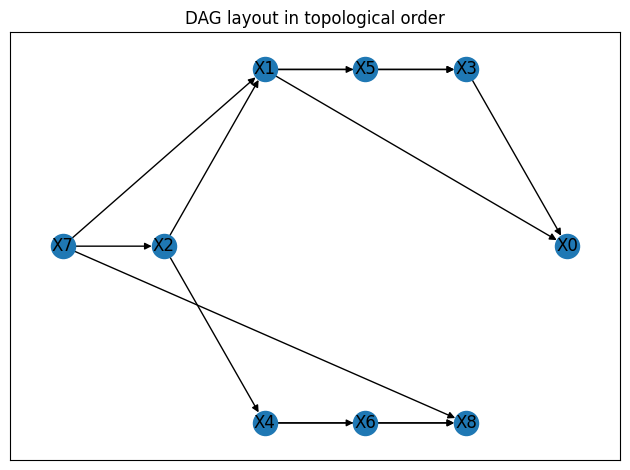

In [0]:
pred_graph_larg = model_large.networkx_graph()
pred_graph_larg = nx.relabel_nodes(pred_graph_larg, {idx:colname for idx, colname in enumerate(colnames_large)})
topological_plot(pred_graph_larg)

In [0]:
# graph_large = model_large.networkx_graph()
# nx.draw_networkx(graph_large, arrows=True, with_labels=True, labels={idx:colname for idx, colname in enumerate(colnames_large)})

The true graph is:


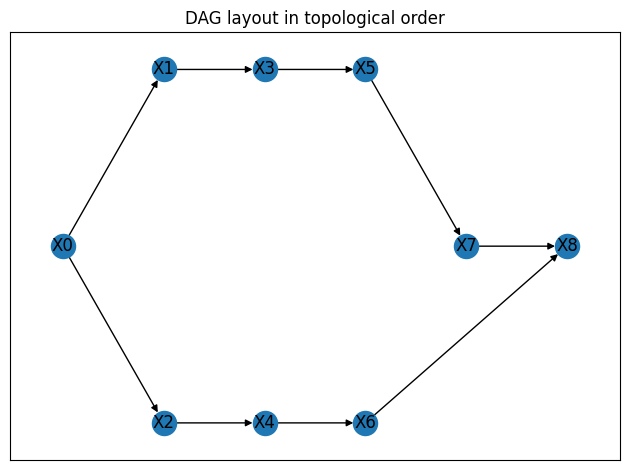

In [0]:
print("The true graph is:")
# nx.draw_networkx(nx.from_pandas_adjacency(gt_effects_large, create_using=nx.DiGraph))
topological_plot(nx.from_pandas_adjacency(gt_effects_large, create_using=nx.DiGraph))


In [0]:
import numpy as np

# intervention_idx= # you can also have more than one index to intervene!

### Model-based ATE estimate
do_1 = model_large.sample(5000, intervention_idxs=np.array([name_to_idx["X7"]]), intervention_values=np.array([2.5])).cpu().numpy()
do_minus_1 = model_large.sample(5000, intervention_idxs=np.array([name_to_idx["X7"]]), intervention_values=np.array([0.5])).cpu().numpy()

# check impact on X8 => index = name_to_idx["X8"]; here we know it is 8!
ate_estimate = do_1[:, 8].mean() - do_minus_1[:, 8].mean()
print("Estimated ATE:", ate_estimate)

Estimated ATE: -0.15827322


In [0]:
set(test_data_large["X7"])

Out[70]: {0.5, 2.5}

In [0]:
# if we do not have an exact match in our test data, we could have an error boundry to get some ground-truth [here we do have!] 
err_dist=0.00001

### Interventional test data ATE
ate_true = test_data_large.loc[abs(test_data_large["X7"]-2.5)<err_dist, "X8"].mean() - test_data_large.loc[
    abs(test_data_large["X7"]-0.5)<err_dist, "X8"].mean()
print("Interventional ATE:", ate_true)


Interventional ATE: -1.4303664934379414


You can see on the last example that neither the graph discovery is perfect nor the results are precise. Training for more epochs &/or incorporating some domain knowledge might improve the results.

# Part 3: Simulation & Imputation
**Imputation:** DECI can tolerate missingness; that is why we use "mask" in the previous examples. This means that not having some values will not harm or break the causal computation process. Beside this functionality, DECI can learn a separate imputation network that can be used to fill in missing data. The current version only supports imputation for _continous_ variables. In order to use that, you would need to set the 'imputation' flag in model_config: `model_config["imputation"]=True`

**Simulation & Causal Inference:** Having a causal model of our data, we can generate simulated data with or without intervention assumption.

For this section, we use the simple dataset from **Part 1** to showcase.

## A) Missing Imputation

### A1) Load Data
We use the same data as part 1, and make some random missingness in it by masking out 5% of the cells:

In [0]:
def make_missing(data, missing_prob=0.05):
    """
    data: numpy array of the data
    missing_prob: portion of data to randomly mask as if it has missed
    """
    mask = np.random.choice([True, False], size=data.shape, p=[1.0-missing_prob, missing_prob])
    missing_data = data.copy()
    missing_data = missing_data * mask.astype(int)
    return missing_data, mask

# create some missingness
data_with_missingness, mask = make_missing(train_data.to_numpy())

### A2) Train model

In [0]:
# DECI configurations
model_config["imputation"]=True
training_params['max_steps_auglag'] = 5
training_params['max_auglag_inner_epochs'] = 2000

dataset_impute = Dataset(train_data=data_with_missingness, train_mask=mask, variables=variables)

model_name_impute = "model_impute"
output_directory_impute = os.path.join(deci_save_directory, dataset_dir+"_impute")

model_impute = DECI.create(model_name_impute, output_directory_impute, dataset_impute.variables, model_config, device=device)
model_impute.run_train(dataset_impute, training_params)

Saving logs to causica_deci_model/csuite_linexp_equal_variance_impute/train_output/summary
Auglag Step: 0
LR: 0.001
Inner Step: 100, loss: 5.53, log p(x|A): -5.45, dag: 0.05430808, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.319, rec: 0.397, penalty_dag_weighed: 7.37e-06, cts_mse_icgnn: 7.14
Inner Step: 200, loss: 4.56, log p(x|A): -4.69, dag: 0.10861616, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.319, rec: 0.189, penalty_dag_weighed: 1.47e-05, cts_mse_icgnn: 7.37
Inner Step: 300, loss: 3.88, log p(x|A): -4.00, dag: 0.05430808, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.288, rec: 0.167, penalty_dag_weighed: 7.37e-06, cts_mse_icgnn: 7.54
Inner Step: 400, loss: 3.37, log p(x|A): -3.48, dag: 0.16292424, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.268, rec: 0.156, penalty_dag_weighed: 2.21e-05, cts_mse_icgnn: 8.25
Inner Step: 500, loss: 3.02, log p(x|A): -3.10, dag: 0.08689293, log p(A)_sp: -0.00, log q(A): -0.000, H filled: 0.240, rec: 0.160, penalty_dag_weighed:

### A3) Imputation Results
Using the following function we can impute the missingness of the data:

In [0]:
# impute
imputed = model_impute.impute(data_with_missingness, mask)

Imputation Evaluation: The scatter plot shows reasonable imputation performance:

Out[75]: [Text(0.5, 0, 'True value'), Text(0, 0.5, 'Imputed value')]

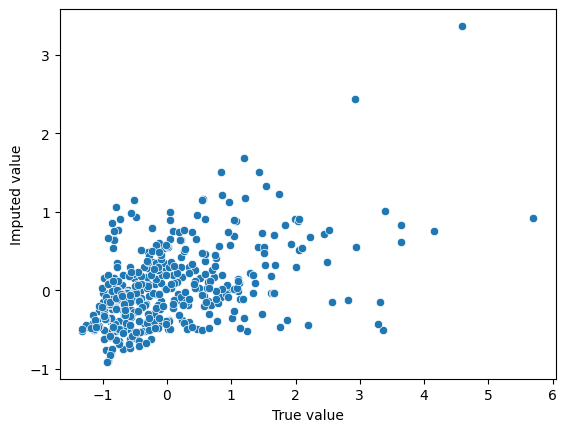

In [0]:
ax = sns.scatterplot(x=train_data.to_numpy()[~mask], y=imputed[~mask])
ax.set(xlabel="True value", ylabel="Imputed value")

## B) Simulation & Inference

### B1) Simulation:
DECI gives us a simulator of the observational distribution.

In [0]:
simulation = pd.DataFrame(model.sample(5000).cpu().numpy(), columns=["A", "B"])

Out[77]: <AxesSubplot: xlabel='A', ylabel='B'>

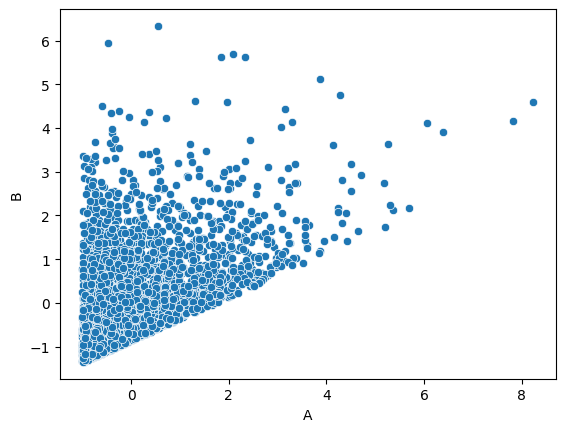

In [0]:
sns.scatterplot(train_data["A"], train_data["B"])

Out[78]: <AxesSubplot: xlabel='A', ylabel='B'>

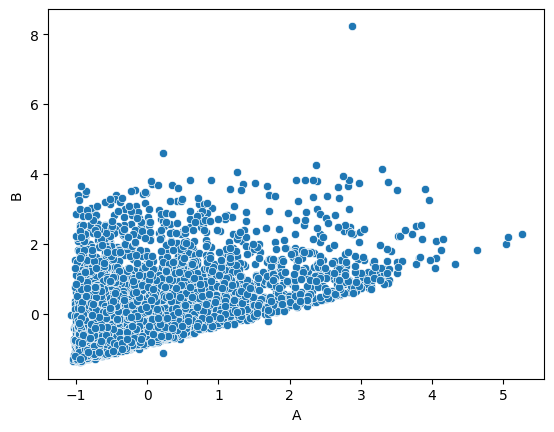

In [0]:
sns.scatterplot(simulation["A"], simulation["B"])

### B2) Causal Inference: Analyzing the results
The DECI model also allows us to simulate from interventional distributions.

In [0]:
simulation_intervention = pd.DataFrame(
    model.sample(5000, intervention_idxs=np.array([0]), intervention_values=np.array([4.])).cpu().numpy(), 
    columns=["A", "B"]
)

In [0]:
simulation_intervention.min()

Out[80]: A    4.000000
B   -1.100328
dtype: float32

Intervening on A causes a change in the values of B.

Out[81]: <AxesSubplot: xlabel='B', ylabel='Density'>

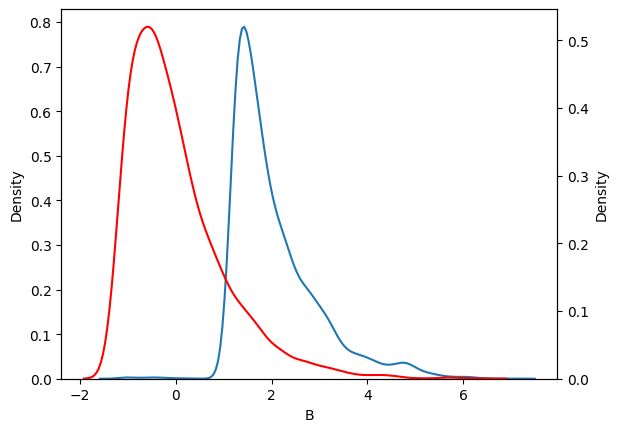

In [0]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.kdeplot(simulation_intervention["B"], ax=ax1)
sns.kdeplot(train_data["B"].astype(np.float32), ax=ax2, color='r')

Intervening on B does not cause a change for A.

In [0]:
simulation_intervention2 = pd.DataFrame(
    model.sample(5000, intervention_idxs=np.array([1]), intervention_values=np.array([1.])).cpu().numpy(), 
    columns=["A", "B"]
)

Out[83]: <AxesSubplot: xlabel='A', ylabel='Density'>

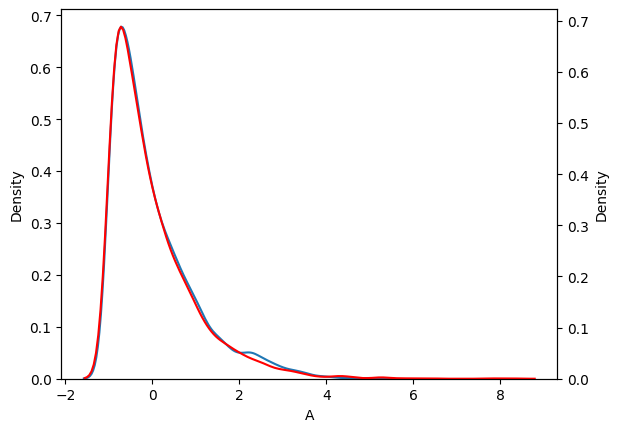

In [0]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.kdeplot(simulation_intervention2["A"], ax=ax1)
sns.kdeplot(train_data["A"].astype(np.float32), ax=ax2, color='r')